# Santander Customer Transaction Prediction
This project attempts to predict which customers will make certain transaction types in the future.

# Imports and setup
First of all, we import all the libraries that will be used in the notebook.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import SMOTE

sns.set()
sns.set_style('dark')

We then load our training and test data.

In [2]:
is_local = True
train_path = ('/kaggle/input/santander-customer-transaction-prediction/train.csv', 'data/train.csv')[int(is_local)]
test_path = ('/kaggle/input/santander-customer-transaction-prediction/test.csv', 'data/test.csv')[int(is_local)]

train_set = pd.read_csv(train_path)
test_set = pd.read_csv(test_path)

## Exploratory Data Analysis
We begin our analysis by exploring the data, looking at what features are available, and the data quality.

In [3]:
train_set.shape

(200000, 202)

In [4]:
train_set.head()

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,...,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,train_1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,...,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518
2,train_2,0,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,...,2.9057,9.7905,1.6704,1.6858,21.6042,3.1417,-6.5213,8.2675,14.7222,0.3965
3,train_3,0,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,...,4.4666,4.7433,0.7178,1.4214,23.0347,-1.2706,-2.9275,10.2922,17.9697,-8.9996
4,train_4,0,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,...,-1.4905,9.5214,-0.1508,9.1942,13.2876,-1.5121,3.9267,9.5031,17.9974,-8.8104


In [5]:
test_set.head()

,ID_code,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,test_0,11.0656,7.7798,12.9536,9.4292,11.4327,-2.3805,5.8493,18.2675,2.1337,...,-2.1556,11.8495,-1.4300,2.4508,13.7112,2.4669,4.3654,10.7200,15.4722,-8.7197
1,test_1,8.5304,1.2543,11.3047,5.1858,9.1974,-4.0117,6.0196,18.6316,-4.4131,...,10.6165,8.8349,0.9403,10.1282,15.5765,0.4773,-1.4852,9.8714,19.1293,-20.9760
2,test_2,5.4827,-10.3581,10.1407,7.0479,10.2628,9.8052,4.8950,20.2537,1.5233,...,-0.7484,10.9935,1.9803,2.1800,12.9813,2.1281,-7.1086,7.0618,19.8956,-23.1794
3,test_3,8.5374,-1.3222,12.0220,6.5749,8.8458,3.1744,4.9397,20.5660,3.3755,...,9.5702,9.0766,1.6580,3.5813,15.1874,3.1656,3.9567,9.2295,13.0168,-4.2108
4,test_4,11.7058,-0.1327,14.1295,7.7506,9.1035,-8.5848,6.8595,10.6048,2.9890,...,4.2259,9.1723,1.2835,3.3778,19.5542,-0.2860,-5.1612,7.2882,13.9260,-9.1846


We see that the train set contains a column for sample ID and a column for the target, as well as 200 features. The test set also contains ID and features, but does not contain target values, as it is supposed to be used for evaluation of competition scores.

Fraction of positive samples: 10.05%


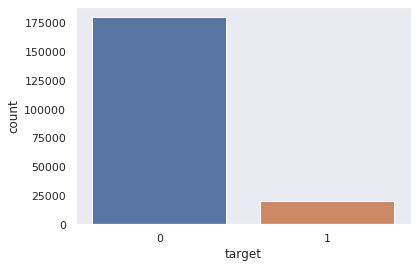

In [6]:
print(f'Fraction of positive samples: {train_set.iloc[:, 1].sum() / train_set.shape[0]:.2%}')
sns.countplot(train_set.iloc[:, 1])

The target value is binary - either the customer makes the transaction, or they don't. We see that only about 10% of the customers actually do make the transaction. This is not a severe imbalance - some datasets may have way fewer positive samples. Howver, we still need to be wary of this - with a skewed distribution such as this, simply predicting a class of 0 for all samples would yield an accuracy of 90%! We will look into balancing the training set during preprocessing.

In [27]:
print(f'Missing values in train set: {train_set.isna().sum().sum()}')
print(f'Missing values in test set: {test_set.isna().sum().sum()}')

Missing values in train set: 0
Missing values in test set: 0


As we can see, neither of the data sets contain any missing values, so we do not need to handle this.

In [28]:
train_set.describe()

,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
count,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,...,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000
mean,0.100490,10.679914,-1.627622,10.715192,6.796529,11.078333,-5.065317,5.408949,16.545850,0.284162,...,3.234440,7.438408,1.927839,3.331774,17.993784,-0.142088,2.303335,8.908158,15.870720,-3.326537
std,0.300653,3.040051,4.050044,2.640894,2.043319,1.623150,7.863267,0.866607,3.418076,3.332634,...,4.559922,3.023272,1.478423,3.992030,3.135162,1.429372,5.454369,0.921625,3.010945,10.438015
min,0.000000,0.408400,-15.043400,2.117100,-0.040200,5.074800,-32.562600,2.347300,5.349700,-10.505500,...,-14.093300,-2.691700,-3.814500,-11.783400,8.694400,-5.261000,-14.209600,5.960600,6.299300,-38.852800
25%,0.000000,8.453850,-4.740025,8.722475,5.254075,9.883175,-11.200350,4.767700,13.943800,-2.317800,...,-0.058825,5.157400,0.889775,0.584600,15.629800,-1.170700,-1.946925,8.252800,13.829700,-11.208475
50%,0.000000,10.524750,-1.608050,10.580000,6.825000,11.108250,-4.833150,5.385100,16.456800,0.393700,...,3.203600,7.347750,1.901300,3.396350,17.957950,-0.172700,2.408900,8.888200,15.934050,-2.819550
75%,0.000000,12.758200,1.358625,12.516700,8.324100,12.261125,0.924800,6.003000,19.102900,2.937900,...,6.406200,9.512525,2.949500,6.205800,20.396525,0.829600,6.556725,9.593300,18.064725,4.836800
max,1.000000,20.315000,10.376800,19.353000,13.188300,16.671400,17.251600,8.447700,27.691800,10.151300,...,18.440900,16.716500,8.402400,18.281800,27.928800,4.272900,18.321500,12.000400,26.079100,28.500700


In [29]:
test_set.describe()

,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
count,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,...,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000
mean,10.658737,-1.624244,10.707452,6.788214,11.076399,-5.050558,5.415164,16.529143,0.277135,7.569407,...,3.189766,7.458269,1.925944,3.322016,17.996967,-0.133657,2.290899,8.912428,15.869184,-3.246342
std,3.036716,4.040509,2.633888,2.052724,1.616456,7.869293,0.864686,3.424482,3.333375,1.231865,...,4.551239,3.025189,1.479966,3.995599,3.140652,1.429678,5.446346,0.920904,3.008717,10.398589
min,0.188700,-15.043400,2.355200,-0.022400,5.484400,-27.767000,2.216400,5.713700,-9.956000,4.243300,...,-14.093300,-2.407000,-3.340900,-11.413100,9.382800,-4.911900,-13.944200,6.169600,6.584000,-39.457800
25%,8.442975,-4.700125,8.735600,5.230500,9.891075,-11.201400,4.772600,13.933900,-2.303900,6.623800,...,-0.095000,5.166500,0.882975,0.587600,15.634775,-1.160700,-1.948600,8.260075,13.847275,-11.124000
50%,10.513800,-1.590500,10.560700,6.822350,11.099750,-4.834100,5.391600,16.422700,0.372000,7.632000,...,3.162400,7.379000,1.892600,3.428500,17.977600,-0.162000,2.403600,8.892800,15.943400,-2.725950
75%,12.739600,1.343400,12.495025,8.327600,12.253400,0.942575,6.005800,19.094550,2.930025,8.584825,...,6.336475,9.531100,2.956000,6.174200,20.391725,0.837900,6.519800,9.595900,18.045200,4.935400
max,22.323400,9.385100,18.714100,13.142000,16.037100,17.253700,8.302500,28.292800,9.665500,11.003600,...,20.359000,16.716500,8.005000,17.632600,27.947800,4.545400,15.920700,12.275800,26.538400,27.907400


_Note: The next couple of plots are huge, creating individual plots for each of 200 features. As such, running them may take significant time._

Next, we plot the distribution of all values in test and train sets:

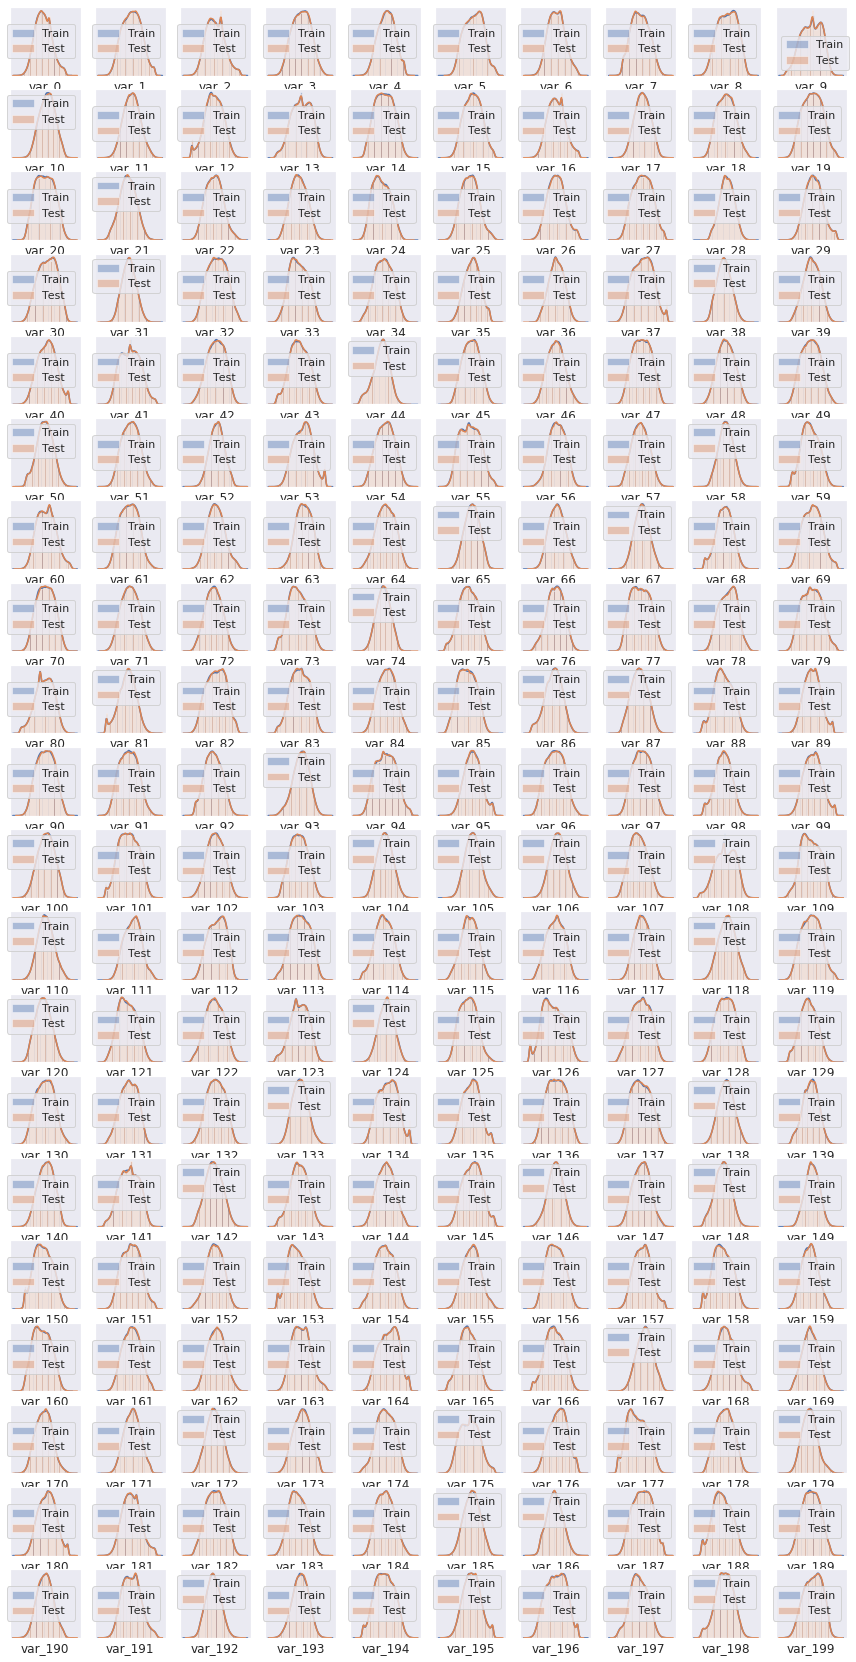

In [30]:
plt.figure(figsize=(15, 30))
for i in range(0, 200):
    feature = train_set.columns[i + 2]
    plt.subplot(20, 10, i + 1)
    plt.xticks([])
    plt.yticks([])
    sns.distplot(train_set[feature], label='Train')
    sns.distplot(test_set[feature], label='Test')
    plt.xlabel(feature)
    plt.legend()
plt.show()

The train and test sets appear to be fairly equally distributed across all features.

We also create a similar plot comparing the distribution in the test set given the target value:

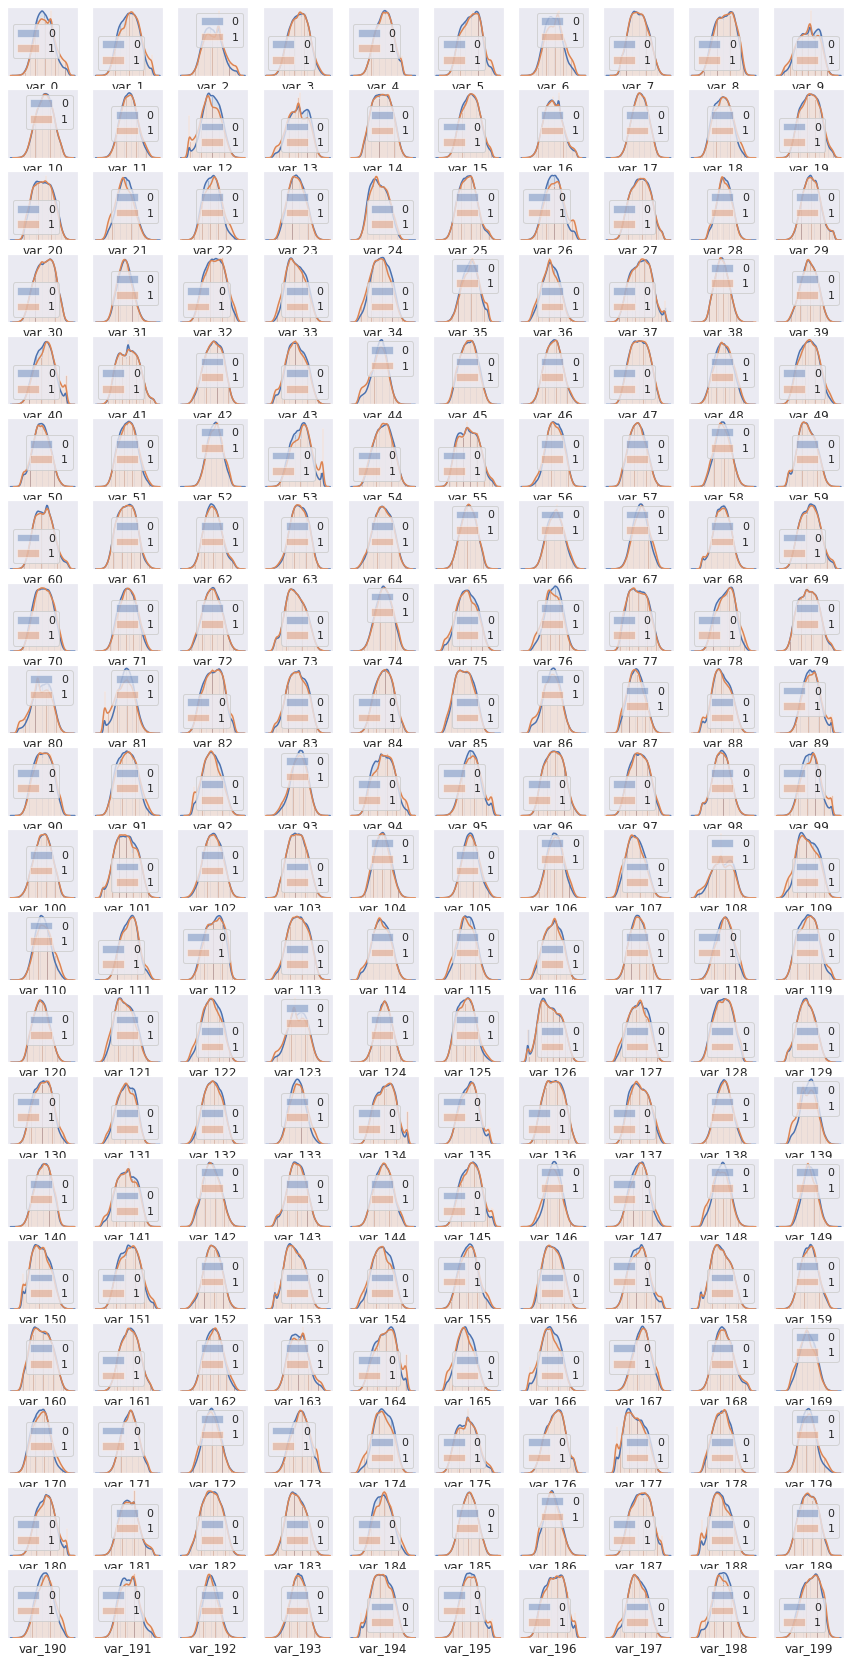

In [31]:
plt.figure(figsize=(15, 30))
for i in range(0, 200):
    feature = train_set.columns[i + 2]
    plt.subplot(20, 10, i + 1)
    plt.xticks([])
    plt.yticks([])
    sns.distplot(train_set[train_set['target'] == 0][feature], label='0')
    sns.distplot(train_set[train_set['target'] == 1][feature], label='1')
    plt.xlabel(feature)
    plt.legend()
plt.show()

This plot shows us that several of the features are differently distributed for our two target values. 

Next, we plot the distributions of mean values and standard deviation for each feature:

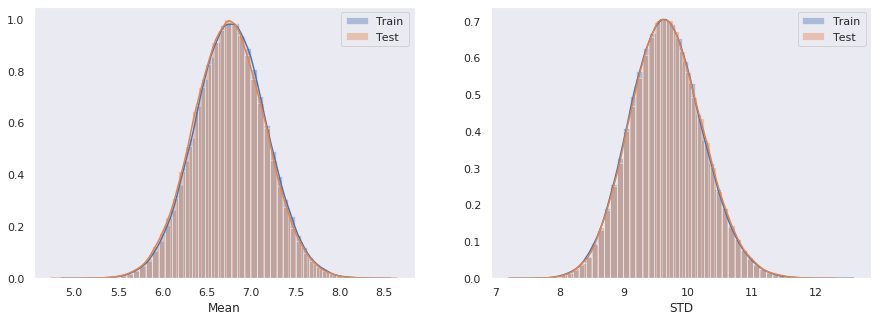

In [32]:
plt.figure(figsize=(15, 5))

plt.subplot(121)
sns.distplot(train_set.iloc[:, 2:].mean(axis=1), label='Train')
sns.distplot(test_set.iloc[:, 2:].mean(axis=1), label='Test')
plt.legend()
plt.xlabel('Mean')

plt.subplot(122)
sns.distplot(train_set.iloc[:, 2:].std(axis=1), label='Train')
sns.distplot(test_set.iloc[:, 2:].std(axis=1), label='Test')
plt.legend()
plt.xlabel('STD')

plt.show()

Below we produce the same plot for the train set filtered by target value:

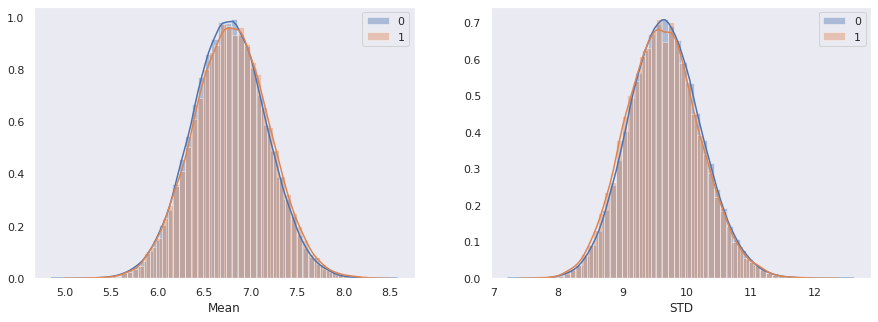

In [33]:
plt.figure(figsize=(15, 5))

plt.subplot(121)
sns.distplot(train_set[train_set['target'] == 0].iloc[:, 2:].mean(axis=1), label='0')
sns.distplot(train_set[train_set['target'] == 1].iloc[:, 2:].mean(axis=1), label='1')
plt.legend()
plt.xlabel('Mean')

plt.subplot(122)
sns.distplot(train_set[train_set['target'] == 0].iloc[:, 2:].std(axis=1), label='0')
sns.distplot(train_set[train_set['target'] == 1].iloc[:, 2:].std(axis=1), label='1')
plt.legend()
plt.xlabel('STD')

plt.show()

Again, we observe that there is a difference in the distributions based on target value. This tells us that there is some correlation here that can be exploited in order to predict the target value.

We now look at the correlation between features. We generally want features with little correlation between each other, as this means less overlap in the information provided by each feature. Little correlation thus gives us more information to use in the prediction of target values.

In [34]:
corr = train_set.iloc[:, 2:].corr()
corr = corr.abs().unstack().reset_index()
corr = corr[corr['level_0'] != corr['level_1']]
corr = corr.sort_values(by=0)

We first show the most correlated pairs of features:

In [35]:
corr.tail(10).iloc[::-1]

,level_0,level_1,0
5339,var_26,var_139,0.009844
27826,var_139,var_26,0.009844
29653,var_148,var_53,0.009788
10748,var_53,var_148,0.009788
16365,var_81,var_165,0.009714
33081,var_165,var_81,0.009714
34881,var_174,var_81,0.009490
16374,var_81,var_174,0.009490
36789,var_183,var_189,0.009359
37983,var_189,var_183,0.009359


We then look at the least correlated pairs of features:

In [36]:
corr.head(10)

,level_0,level_1,0
15191,var_75,var_191,2.703975e-08
38275,var_191,var_75,2.703975e-08
1373,var_6,var_173,5.942735e-08
34606,var_173,var_6,5.942735e-08
21926,var_109,var_126,1.313947e-07
25309,var_126,var_109,1.313947e-07
5544,var_27,var_144,1.772502e-07
28827,var_144,var_27,1.772502e-07
35500,var_177,var_100,3.116544e-07
20177,var_100,var_177,3.116544e-07


As can bee seen, none of the correlations are particularly high.

We can also have a look at the correlations between individual features and the target value:

In [37]:
corr2 = train_set.iloc[:, 2:].corrwith(train_set['target'])
corr2 = corr2.abs().reset_index()
corr2 = corr2.sort_values(by=0)
corr2.tail(10).iloc[::-1]

,index,0
81,var_81,0.080917
139,var_139,0.074080
12,var_12,0.069489
6,var_6,0.066731
110,var_110,0.064275
146,var_146,0.063644
53,var_53,0.063399
26,var_26,0.062422
76,var_76,0.061917
174,var_174,0.061669


Our highest correlations are better here than when comparing features with each other, but there is no single feature with a particularly high correlation with the target. This means that any patterns in the data must necessarily be a function of several features.

# Pre-Processing

As mentioned above, there are no missing values that need to be handled during preprocessing. However, processing the data to engineer good features is still an important part of the training process (although the introduction of Deep Learning has enabled end-to-end training, including learning relevant features).

We will attempt several pre-processing techniques in order to produce accurate predictions.

## Data set reduction
In order to speed up training when evaluating models, we use only a subset of the full dataset, using the full dataset only to train the final model when we have selected an architecture and hyperparameters. The dataset is reduces using stratified sampling, which ensures that the distribution of target values is kept.

In [7]:
REDUCE_TRAIN_SET = False
train_samples = 50000
sample_frac = train_samples / train_set.shape[0]

if REDUCE_TRAIN_SET:
    train_set_reduced = train_set.groupby('target', group_keys=False).apply(lambda x: x.sample(frac=sample_frac))
    train_data = train_set_reduced
else:
    train_data = train_set

test_data = test_set.copy()

In [8]:
train_data.shape

(200000, 202)

We can now do a simple check to confirm that the fraction of positive samples is still the same:

In [9]:
print(f'Fraction of positive samples: {train_data.iloc[:, 1].sum() / train_data.shape[0]:.2%}')

Fraction of positive samples: 10.05%


The train set contains an ID_code column. We don't need it, so we simply drop it to avoid issues later on.

In [10]:
train_data = train_data.drop('ID_code', axis=1)

## Balancing the Dataset

Next, we handle the problem of unbalanced data. We can choose one of two different techniques for this. The first is undersampling, where we simply remove random samples in order to balance the data. However, we then lose valuable information. We therefore choose the second approach, which is oversampling. This is slightly more complicated: we generate new positive samples that are similar to the current ones. The technique we use is called SMOTE (Synthetic Minority Over-sampling TEchnique), which looks at the nearest neighbours of our positive class. Luckily, library implementations of the method exist, so that we don't have to do the actual implementation ourselves.

In [11]:
sm = SMOTE(sampling_strategy='minority', random_state=0)

oversampled_train_x, oversampled_train_y = sm.fit_sample(train_data.drop('target', axis=1), train_data['target'])
oversampled_train = pd.concat([pd.DataFrame(oversampled_train_y), pd.DataFrame(oversampled_train_x)], axis=1)
oversampled_train.columns = train_data.columns

train_data = oversampled_train

In [12]:
train_data.shape

(359804, 201)

We then check the new distribution of target values:

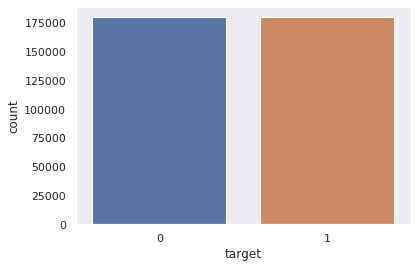

In [13]:
sns.countplot(train_data.iloc[:, 0])

As we can see, we now have a perfectly balanced dataset. This will facilitate much better training.

## Feature Engineering

We add a number of features that are statistical properties of the data rows:

In [14]:
train_features = train_data.iloc[:, 1:]
test_features = test_data.iloc[:, 1:]

In [15]:
train_data['sum'] = train_features.sum(axis=1)
train_data['mean'] = train_features.mean(axis=1)
train_data['min'] = train_features.min(axis=1)
train_data['max'] = train_features.max(axis=1)
train_data['std'] = train_features.std(axis=1)
train_data['median'] = train_features.median(axis=1)
train_data['skew'] = train_features.skew(axis=1)
train_data['kurt'] = train_features.kurt(axis=1)

In [16]:
test_data['sum'] = test_features.sum(axis=1)
test_data['mean'] = test_features.mean(axis=1)
test_data['min'] = test_features.min(axis=1)
test_data['max'] = test_features.max(axis=1)
test_data['std'] = test_features.std(axis=1)
test_data['median'] = test_features.median(axis=1)
test_data['skew'] = test_features.skew(axis=1)
test_data['kurt'] = test_features.kurt(axis=1)

In [17]:
train_data.head()

,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_198,var_199,sum,mean,min,max,std,median,skew,kurt
0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,-4.9200,...,12.7803,-1.0914,1456.3182,7.281591,-21.4494,43.1127,9.331540,6.77040,0.101580,1.331023
1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,3.1468,...,18.3560,1.9518,1415.3636,7.076818,-47.3797,40.5632,10.336130,7.22315,-0.351734,4.110215
2,0,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,-4.9193,...,14.7222,0.3965,1240.8966,6.204483,-22.4038,33.8820,8.753387,5.89940,-0.056957,0.546438
3,0,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,-5.8609,...,17.9697,-8.9996,1288.2319,6.441160,-35.1659,38.1015,9.594064,6.70260,-0.480116,2.630499
4,0,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,6.2654,...,17.9974,-8.8104,1354.2310,6.771155,-65.4863,41.1037,11.287122,6.94735,-1.463426,9.787399


In [18]:
test_set.head()

,ID_code,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,test_0,11.0656,7.7798,12.9536,9.4292,11.4327,-2.3805,5.8493,18.2675,2.1337,...,-2.1556,11.8495,-1.4300,2.4508,13.7112,2.4669,4.3654,10.7200,15.4722,-8.7197
1,test_1,8.5304,1.2543,11.3047,5.1858,9.1974,-4.0117,6.0196,18.6316,-4.4131,...,10.6165,8.8349,0.9403,10.1282,15.5765,0.4773,-1.4852,9.8714,19.1293,-20.9760
2,test_2,5.4827,-10.3581,10.1407,7.0479,10.2628,9.8052,4.8950,20.2537,1.5233,...,-0.7484,10.9935,1.9803,2.1800,12.9813,2.1281,-7.1086,7.0618,19.8956,-23.1794
3,test_3,8.5374,-1.3222,12.0220,6.5749,8.8458,3.1744,4.9397,20.5660,3.3755,...,9.5702,9.0766,1.6580,3.5813,15.1874,3.1656,3.9567,9.2295,13.0168,-4.2108
4,test_4,11.7058,-0.1327,14.1295,7.7506,9.1035,-8.5848,6.8595,10.6048,2.9890,...,4.2259,9.1723,1.2835,3.3778,19.5542,-0.2860,-5.1612,7.2882,13.9260,-9.1846


Next, we separate the features from the labels:

In [19]:
train_x = train_data.iloc[:, 1:].values
train_y = train_data.iloc[:, 0].values

Many machine learning methods perform better on normalized data - i.e. data where each feature has been scaled to have zero mean and unit variance.

In [20]:
train_x_scaled = preprocessing.scale(train_x)

# Model Selection and Training
The next step is selecting a model type and fitting it to the training data.

> ### Note on cross-validation
> We already have two data sets, labeled train and test. However, the test data set is meant to be used for the competition submission, and does not contain labels. In order to carry out cross validation, we must therefore further split the train data. We can either use train and validation sets, or k-fold cross validation.

We begin by fitting a Random Forest classifier using the scaled data. 

In [21]:
X = train_data.iloc[:, 1:].values
y = train_data.iloc[:, 0].values
kfold = StratifiedKFold(n_splits=10, random_state=0)
x_train, x_val, y_train, y_val = train_test_split(X, y, stratify=y)

In [53]:
%%time
rfc = RandomForestClassifier(n_estimators=100, criterion='entropy', n_jobs=-1, random_state=0)
rfc.fit(x_train, y_train)
#result = cross_val_score(rfc, X, y, cv=kfold)
#print(f'10-fold accuracy: {result.mean():.2%}')

CPU times: user 25min 51s, sys: 798 ms, total: 25min 51s
Wall time: 3min 24s


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [54]:
preds_train = rfc.predict(x_train)
acc = accuracy_score(y_train, preds_train)
print(f'Train set accuracy: {acc:.3%}')
pd.crosstab(y_train, preds_train, rownames=['Actual'], colnames=['Predicted'])

Train set accuracy: 100.000%


Predicted,0,1
Actual,,
0,134926,0
1,0,134927


In [55]:
preds_val = rfc.predict(x_val)
acc = accuracy_score(y_val, preds_val)
print(f'Validation set accuracy: {acc:.3%}')
pd.crosstab(y_val, preds_val, rownames=['Actual'], colnames=['Predicted'])

Validation set accuracy: 94.945%


Predicted,0,1
Actual,,
0,43267,1709
1,2838,42137


We see that our random forest classifies the train set perfectly, while the accuracy is somewhat lower on the validation set. This indicates that the complexity of our model is sufficient to model the data set, but we don't have perfect generalization. This might be due to slight overfitting. However, the accuracy on the test set is still good, and we see from the confusion matrix that there is some bias, but not an excessive amount.

We can now create the predictions on the test using this model:

In [57]:
x_test = test_data.iloc[:, 1:].values

preds_test = rfc.predict(x_test)

Below, we prepare a submission file using the calculated predictions:

In [58]:
submission = pd.DataFrame({'ID_code': test_data['ID_code'], 'target': preds_test})
submission.to_csv('submission.csv', index=False)

Submitting this result yields a score of 0.52655, which is indeed quite poor. Since we achieve good scores on the train set, the problem is a lack of generalization - the model is overfitting to our train data.

A reason that we don't discover this using the validation set, could be the implementation of oversampling. We have done this before splitting into train and validation sets. Since oversampling is done by creating new samples based on the old one, there is some sense of dependence between train and validation sets, which could lead to misguiding results.

Next up, we'll try fitting an AdaBoost classifier. This is a boosting classifier, which needs to run sequentially. We are therefore unable to parallelize the training, so it takes longer than the RandomForest classifier.

In [23]:
ada = AdaBoostClassifier(n_estimators=100, learning_rate=0.5, random_state=0)
#result = cross_val_score(ada, X, y, cv=kfold)
#print(f'10-fold accuracy: {result.mean():.2%}')
#ada.fit(x_train, y_train)

In [60]:
preds_val = ada.predict(x_val)
acc = accuracy_score(y_val, preds_val)
print(f'Validation set accuracy: {acc:.3%}')
pd.crosstab(y_val, preds_val, rownames=['Actual'], colnames=['Predicted'])

Validation set accuracy: 81.414%


Predicted,0,1
Actual,,
0,36849,8127
1,8591,36384


In [61]:
preds_train = ada.predict(x_train)
acc = accuracy_score(y_train, preds_train)
print(f'Train set accuracy: {acc:.3%}')
pd.crosstab(y_train, preds_train, rownames=['Actual'], colnames=['Predicted'])

Train set accuracy: 81.719%


Predicted,0,1
Actual,,
0,111440,23486
1,25845,109082


In [63]:
feature_importance = pd.DataFrame()
feature_importance['feature'] = train_data.columns.values[1:]
feature_importance['importance'] = ada.feature_importances_
feature_importance = feature_importance.sort_values(by='importance', ascending=False)

In [64]:
feature_importance.head()

,feature,importance
204,std,0.05
45,var_45,0.02
81,var_81,0.02
0,var_0,0.01
116,var_116,0.01


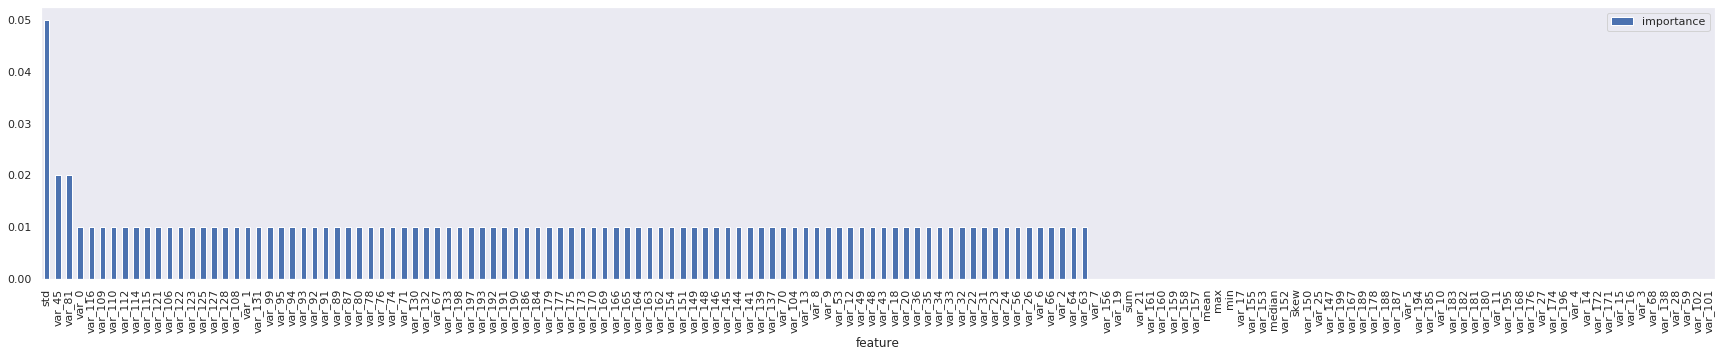

In [65]:
feature_importance.iloc[:150,:].plot.bar(x='feature', y='importance', figsize=(30, 5))

Interestingly, the standard deviation is determined to be the most important feature, while no other enhanced feature is given any weight at all.

We see that the AdaBoost model performs worse on the train set, but generalizes better. This indicates that the model is not trained strongly enough. We will use a randomized parameter search to attempt to find better hyperparameters.

In [ ]:
param_grid = {
    'n_estimators': [50, 100],
    'learning_rate': [0.01, 0.05, 0.1, 0.3, 0.5, 1.0],
    'algorithm': ['SAMME', 'SAMME.R']
}

ada_grid = RandomizedSearchCV(estimator=AdaBoostClassifier(), cv=3, verbose=2, param_distributions=param_grid, n_jobs=-1, return_train_score=True)
ada_grid.fit(x_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


In [ ]:
ada_grid.best_score_

In [ ]:
ada_grid.best_params_

An interesting attribute of the AdaBoost classifier is the assigned importances of the features. This can give us an indication of which features are useful for classification.

In [27]:
feature_importance = pd.DataFrame()
feature_importance['feature'] = train_data.columns.values[1:]
feature_importance['importance'] = ada_grid.best_estimator_.feature_importances_
feature_importance = feature_importance.sort_values(by='importance', ascending=False)

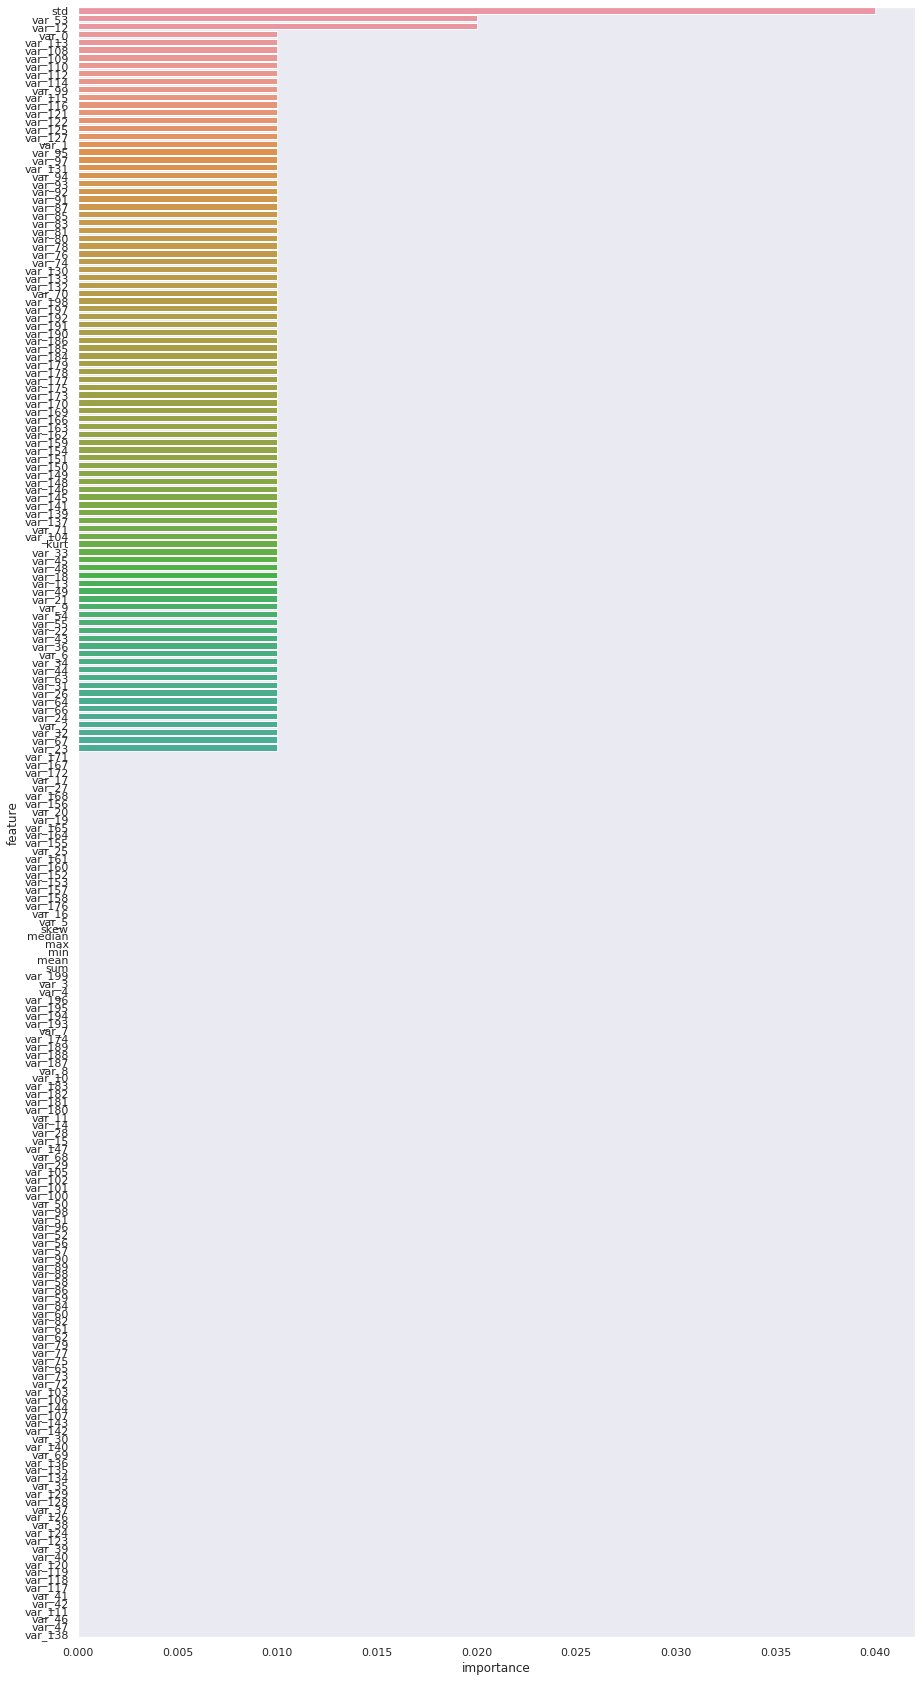

In [28]:
plt.figure(figsize=(15, 30))
sns.barplot(x='importance', y='feature', data=feature_importance)
plt.show()

At the moment, all features are assigned a very small importance, which indicates that our classifier is very weakly trained.

We now try to do a parameter search over the RandomForest classifier, to see if we can build a better model out of it.

In [29]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

rfc = RandomForestClassifier(random_state=0)

rfc_random = RandomizedSearchCV(estimator=rfc, param_distributions=random_grid,
                              n_iter = 100, scoring='neg_mean_absolute_error', 
                              cv = 3, verbose=2, random_state=42, n_jobs=-1,
                              return_train_score=True)
rfc_random.fit(X, y)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


TerminatedWorkerError: A worker process managed by the executor was unexpectedly terminated. This could be caused by a segmentation fault while calling the function or by an excessive memory usage causing the Operating System to kill the worker. The exit codes of the workers are {SIGKILL(-9)}

In [ ]:
rfc_random.best_params_

In [ ]:
rfc_random.best_score_

The below code enables downloading the submissions file directly from the kernel on Kaggle:

In [ ]:
from IPython.display import FileLink
FileLink(r'submission.csv')